# Decision Trees Exercises

## Introduction

We will be using the wine quality data set for these exercises. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data.csv`.

In [2]:
from __future__ import print_function
import os
data_path = ['data']

## Question 1

* Import the data and examine the features.
* We will be using all of them to predict `color` (white or red), but the colors feature will need to be integer encoded.

In [3]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Wine_Quality_Data.csv'])
data = pd.read_csv(filepath, sep=',')
data

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


## Question 2

* Use `StratifiedShuffleSplit` to split data into train and test sets that are stratified by wine quality. If possible, preserve the indices of the split for question 5 below.
* Check the percent composition of each quality level for both the train and test data sets.

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=42)

#Split the data from features and target
X = data.drop('color', axis=1)
y = data.color

#Turning color into integers
y = y.replace('white', 0).replace('red',1).astype(int)

#Get data with training-test index
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    

#Percent compostion of quality column
print('Y-train composition')
print(y_train.value_counts(normalize=True))
print('Y-test composition')
print(y_test.value_counts(normalize=True))

Y-train composition
0    0.753866
1    0.246134
Name: color, dtype: float64
Y-test composition
0    0.754
1    0.246
Name: color, dtype: float64


## Question 3

* Fit a decision tree classifier with no set limits on maximum depth, features, or leaves.
* Determine how many nodes are present and what the depth of this (very large) tree is.
* Using this tree, measure the prediction error in the train and test data sets. What do you think is going on here based on the differences in prediction error?

In [25]:
from sklearn.tree import DecisionTreeClassifier

#Creating and fitting the tree
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

#Determining how many nodes and its depth
print(f'Amount of nodes: {dt.get_n_leaves()}')
print(f'Depth of tree: {dt.get_depth()}')

Amount of nodes: 86
Depth of tree: 22


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Measure error function
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy': accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)}, name=label)

In [27]:
#Predictions on training and testing data
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_error = pd.concat([measure_error(y_train, y_train_pred, 'train'), 
                              measure_error(y_test, y_test_pred, 'test')], axis=1)
train_test_error

,train,test
accuracy,0.999818,0.984000
precision,0.999261,0.963710
recall,1.000000,0.971545
f1,0.999631,0.967611


## Question 4

* Using grid search with cross validation, find a decision tree that performs well on the test data set. Use a different variable name for this decision tree model than in question 3 so that both can be used in question 6.
* Determine the number of nodes and the depth of this tree.
* Measure the errors on the training and test sets as before and compare them to those from the tree in question 3.

In [28]:
from sklearn.model_selection import GridSearchCV

#Parameters to optimized via GridSearch
parameters = {'max_depth': range(1, dt.tree_.max_depth+1, 2),
             'max_features': range(1, dt.max_features_)}

#Gridsearch instance
dt2 = DecisionTreeClassifier(random_state=42)
dt_gs = GridSearchCV(dt2, parameters, cv=5)

#Fitting the model
dt_gs.fit(X_train, y_train)

#Number of nodes and depth
print(f'Amount of nodes: {dt_gs.best_estimator_.get_n_leaves()}')
print(f'Depth of tree: {dt_gs.best_estimator_.get_depth()}')

Amount of nodes: 50
Depth of tree: 7


In [29]:
#Predictions on training and testing data
y_train_pred2 = dt_gs.predict(X_train)
y_test_pred2 = dt_gs.predict(X_test)

train_test_error = pd.concat([measure_error(y_train, y_train_pred2, 'train'), 
                              measure_error(y_test, y_test_pred2, 'test')], axis=1)
train_test_error

,train,test
accuracy,0.995816,0.989000
precision,0.998501,0.983539
recall,0.984479,0.971545
f1,0.991440,0.977505


## Question 5

* Re-split the data into `X` and `y` parts, this time with `residual_sugar` being the predicted (`y`) data. *Note:* if the indices were preserved from the `StratifiedShuffleSplit` output in question 2, they can be used again to split the data.
* Using grid search with cross validation, find a decision tree **regression** model that performs well on the test data set.
* Measure the errors on the training and test sets using mean squared error.
* Make a plot of actual *vs* predicted residual sugar.

In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import sklearn

#Splitting data
X = data.drop('residual_sugar', axis=1)
X['color'] = X['color'].replace('white', 0).replace('red',1).astype(int)
y = data.residual_sugar

#Creating training and test data split
X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]
    
#Tree regression instance
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [31]:
#Parameters
parameters = {'max_depth': range(1, dt_reg.tree_.max_depth+1, 2), 'max_features': range(1, dt_reg.max_features_)}

#GridSearch instance
dtr_gs = GridSearchCV(dt_reg, parameters, cv=5)
dtr_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=42,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(1, 33, 2),
                         'max_features': range(1, 12)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, 

In [55]:
#Predictions
y_train_pred_dtr = dtr_gs.predict(X_train)
y_test_pred_dtr = dtr_gs.predict(X_test)

#Errors
train_test_mse = pd.Series({'train_mse': mean_squared_error(y_train, y_train_pred_dtr),
                      'test_mse': mean_squared_error(y_test, y_test_pred_dtr)}, name='MSE').to_frame()



train_test_mse

,MSE
train_mse,0.001805
test_mse,2.643804


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

%matplotlib inline

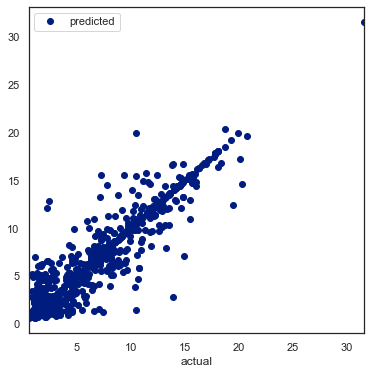

In [68]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ph_test_prediction = pd.DataFrame({'actual': y_test, 'predicted': y_test_pred_dtr}).set_index('actual').sort_index()

ph_test_prediction.plot(marker='o', ls='', ax=ax)

## Question 6 *(Optional)*

This question is optional as it requires an additional command line program (GraphViz) and Python library (PyDotPlus). GraphViz can be installed with a package manager on Linux and Mac. For PyDotPlus, either `pip` or `conda` (`conda install -c conda-forge pydotplus`) can be used to install the library.

Once these programs are installed:

* Create a visualization of the decision tree from question 3, where wine color was predicted and the number of features and/or splits are not limited.
* Create a visualization of the decision tree from question 4, where wine color was predicted but a grid search was used to find the optimal depth and number of features.

The decision tree from question 5 will likely have too many nodes to visualize.

In [12]:
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

[3, 4, 5, 6, 7]

[1234, None, None, None, None, None, None, None, None, None]

[1, 2, 3]

106